In [1]:
# !pip install -U -q langchain langchain-chroma pypdf sentence-transformers langgraph langchain_openai langchain_community pymysql


### Initialize LLM

In [1]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")

### Summarize Ticket Tool

In [2]:
import requests
import os
FRESHDESK_API_KEY = os.getenv("FRESHDESK_API_KEY")
FRESHDESK_URL = os.getenv("FRESHDESK_URL")

def get_messages(ticket_id):
    url= f'https://{FRESHDESK_URL}.freshdesk.com/api/v2/tickets/{ticket_id}?include=conversations'
    headers = {
        'Content-Type': 'application/json'
    }
    auth = (FRESHDESK_API_KEY, 'X')  # Replace 'X' with your actual API key
    response = requests.get(url, headers=headers, auth=auth)
    return response.json()

In [3]:
def process_messages(messages):
    subject = messages['subject']
    description = messages['description_text']
    conversation = messages['conversations']
    messages = ""
    messages += "Subject : " + subject + "\n"
    messages += "User query : \n" + description + "\n"
    for message in conversation:
        if message['incoming']:
            messages += "User Query : \n" + message['body_text'] + "\n"
        else:
            messages += "Agent Response : \n" + message['body_text'] + "\n"
    return messages

In [6]:
# message = get_messages(232536)
# process_message = process_messages(message)
# process_message

In [4]:
from langchain.tools import tool
from pydantic import BaseModel
from langchain_core.prompts import ChatPromptTemplate

class SummarizeToolSchema(BaseModel):
    ticket_id: int
    
@tool(args_schema=SummarizeToolSchema)
def summarize_tool(ticket_id: int):
    """Tool to Summarize Ticket information based on ticket_id provided
    `ticket_id`: int"""
    print("INSIDE SUMMARIZE NODE", ticket_id)
    # Invoke chain
    data = get_messages(ticket_id)
    context = process_messages(data)
    print(context)
    
    # Define prompt
    prompt = ChatPromptTemplate.from_messages(
        [("system", """FutureSmart TechStore is committed to being the leading destination for technology enthusiasts worldwide by combining quality, value, and exceptional service. At FutureSmart TechStore, we don’t just sell products—we provide solutions that enhance your lifestyle and work environment. We aim to offer great value to our customers through a range of promotions and discounts, ensuring you get the best deals on the latest technology products.

    Our collection includes a wide range of tech products designed to meet the needs of various customers, Our collection includes a wide range of tech products such as Smart Home Solutions (intelligent lighting systems, advanced security devices), Wearable Technology (fitness trackers, smartwatches), Mobile Accessories (chargers, cases, screen protectors), and Computing Peripherals (keyboards, mice, storage devices), designed to meet the needs of various customers, from tech enthusiasts to everyday users.

    If the query is not in English, please identify the language and generate a summary of the conversation in English. The response should be generated in the same language as the query.Also mention order id and customer name if present.\\n\\n{context}. Summarize:""")]
    )

    # Instantiate chain
    chain = prompt | llm
    result = chain.invoke({"context": context})
    return f"ticket_id: {ticket_id}", f"Ticket Summary: {result.content}"

In [17]:
summarize_tool.invoke({"ticket_id":100})

INSIDE SUMMARIZE NODE 100
Subject : Order 8
User query : 
Dear Support Team,  I am deeply disappointed that my USB-C Charger (Order #8), expected by Dec 23, did not arrive in time for an important occasion. To make matters worse, I was informed I cannot cancel the order. Please provide an update on when I will receive the item.  I hope for a prompt resolution.  Thank you.



('ticket_id: 100',
 'Ticket Summary: Subject: Order 8\n\nCustomer Name: Not provided\n\nThe customer is disappointed because their USB-C Charger (Order #8), expected by December 23, did not arrive in time for an important occasion. They have also been informed that they cannot cancel the order and are requesting an update on when they will receive the item. They are hoping for a prompt resolution.')

### RAG Tool

In [6]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "docs/"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 14 documents from the folder.


In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 22 chunks.


In [5]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embedding_function = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

s:\FutureSmartAI\ecommerce_pradeep\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

C:\Users\shrey\AppData\Local\Temp\ipykernel_11656\3563061202.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(
s:\FutureSmartAI\ecommerce_pradeep\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vector store created and persisted to './chroma_db'


In [12]:
# retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
# retriever_results = retriever.invoke("Where is the team of Futuresmart located?")
# print(retriever_results)

In [6]:
from langchain.tools import tool
from pydantic import BaseModel
from langchain_chroma import Chroma
    
class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question: str):
    """Tool to Retrieve Information from Relevant documents related to FutureSmart Tech Store Company Overview, Contact Information, Payment methods, privacy policy, discount, shipping and warranty policy, etc. Must get all necessary information before replying to a ticket
    `question`: str"""
    print("INSIDE RETRIEVER NODE", question)
    vectorstore = Chroma(collection_name="my_collection", embedding_function=embedding_function, persist_directory="./chroma_db")
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
    retriever_result = retriever.invoke(question)
    context = "\n\n".join(doc.page_content for doc in retriever_result)
    
    return f"(context: {context})"

In [25]:
retriever_tool.invoke({"question": "what are different payment methods supported"})

INSIDE RETRIEVER NODE what are different payment methods supported


'(context: At FutureSmart TechStore, weaimtomakeyourshoppingexperienceasseamlessandsecureaspossible. Wesupport avarietyof payment methodstosuit yourconvenience.\nSupportedPaymentMethods\n1. CreditandDebitCards○ Visa○ Mastercard○ AmericanExpress○ RuPay2. DigitalWallets○ Paytm○ PhonePe○ GooglePay○ AmazonPay3. NetBanking○ Supportedforall majorIndianbanksincludingHDFC, ICICI, SBI, AxisBank, andmore.4. UPIPayments○ SeamlesspaymentsusingUnifiedPaymentsInterface(UPI).5. CashonDelivery(COD)○ Availableforselect locationsinIndia.○ MaximumCODlimit: INR10,000.6. EMIOptions○ No-cost EMI andstandardEMI optionsareavailableformajorcredit cards.○ EMI optionsdependonthebankandcardtype.7. BankTransfers○ Direct banktransfersaresupportedforbulkorbusinesspurchases.\nPaymentSecurity\n● All onlinetransactionsareprocessedthroughsecureandencryptedgatewaystoensurethesafetyof yourinformation.● Wecomplywiththelatest PCI DSS(Payment CardIndustryDataSecurityStandard)guidelines.\nImportantNotes\n\nAt FutureSmart Tech

### NL2SQL Tool

In [7]:
from langchain_community.utilities import SQLDatabase
import os
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db = SQLDatabase.from_uri(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}",sample_rows_in_table_info=1)

In [8]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # print(text)
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)
    # print(text)
    return text

In [9]:
from langchain_community.tools import QuerySQLDatabaseTool

def get_sql_chain():
    execute_query = QuerySQLDatabaseTool(db=db)
    
    
    prompt = ChatPromptTemplate.from_messages(
        [("system", """You are a MySQL expert. Given an input question, create a syntactically correct MySQL query to run. Use the LIKE operator for all string matching queries, ensuring proper use of wildcards (% or _) for partial matches. Only use = operator when quering for order_id or product_id column.
        Here is the relevant table information: {table_info}"""),
        ("human", "{human_message}" )]
    )
    write_query = prompt | llm | StrOutputParser()

    chain = (
        RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
            result=itemgetter("query") | execute_query
        )
    )
    return chain

In [10]:

from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from typing import Optional 

class SQLToolSchema(BaseModel):
    question: str
    order_id: Optional[str] = ""
    product_id: Optional[str] = ""

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question: str, order_id: Optional[str] = "", product_id: Optional[str] = ""):
  """Tool to get Product detail or Order status. Must get Order details before responding to a ticket
  `question`: str, `order_id`: str, `product_id`: str"""

  print("INSIDE NL2SQL TOOL", question)
  chain = get_sql_chain()
  table_info = db.get_table_info() 
  human_message = f"question: {question}, order id: {order_id}, product_id: {product_id}, sql_query:" 
  print("human_message:", human_message)
  response = chain.invoke({"human_message": human_message, "table_info":table_info})
  return f"Product detail and Order status: {response['result']}, SQL Query used:{response['query']}"


In [85]:
question = "Check Order status"
order_id = "8"
product_id = ""
result = nl2sql_tool.invoke({"question": question,"order_id": order_id, "product_id":product_id})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL Check Order status
human_message: question: Check Order status, order id: 8, product_id: , sql_query:
Question: Check Order status
Answer: Product detail and Order status: [('Processing',)], SQL Query used:SELECT order_status 
FROM Orders 
WHERE order_id = 8;


### Reply Tool

In [11]:
def create_reply(ticket_id, body):
    try:
        url = f'https://{FRESHDESK_URL}.freshdesk.com/api/v2/tickets/{ticket_id}/reply'
        headers = {
            'Content-Type': 'application/json'
        }
        auth = (FRESHDESK_API_KEY, 'X')  # Replace 'X' with your actual API key
        data = {
            "body": body
        }
        response = requests.post(url, headers=headers, auth=auth, json=data)
        return response.json()
    except Exception as e:
        print("Error in create_reply : ", e)
        return ""

In [12]:
from langchain.tools import tool
from pydantic import BaseModel

class ReplyToTicket(BaseModel):
    information: str
    ticket_id: str
    
@tool(args_schema=ReplyToTicket)
def reply_to_ticket_tool(information: str, ticket_id: str):
    """Tool that will send a reply to customer with a ticket id
    `information`: str, 
    `ticket_id`: str"""
    
    print("INSIDE REPLY TOOL", ticket_id)
    import datetime
    current_time = datetime.date.today()
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""
**Introduction to FutureSmart TechStore:**
FutureSmart TechStore is a leading retailer specializing in cutting-edge technology products, ensuring you have access to the latest innovations to meet your needs. We pride ourselves on our customer service and offer support in multiple languages to cater to our diverse clientele. Our inventory includes a wide range of electronics, smart home devices, and accessories, all curated to enhance your tech lifestyle.

**Guidelines for Responding to Customer Queries:**

Current date and time is "{current_time}. Use the current date and time for generating time sensitive responses.
**Identify Language and Respond in English:**
   Analyze the language of the customer's query to ensure accurate understanding. While responding, provide all replies in English to maintain consistency.

**Order Information and Query Specifics:**
   Utilize provided order details to address specific customer queries accurately. Ensure responses are tailored to address only the aspects of the order that the customer has inquired about. Do not include unnecessary order details unless requested.

By adhering to these guidelines, ensure that your responses are informative, accurate, and aligned with FutureSmart TechStore's commitment to customer satisfaction. Remember to always maintain a friendly and professional tone in all communications.

You are an AI assistant tasked with crafting a professional customer reply in Gmail format. Mention FutureSmart TechStore Support, 9876543210 Phone number. Avoid placeholders or incomplete information, and provide clear, actionable steps to resolve the issue"""),
        ("human", "context: {information}" )
    ])
    chain = prompt | llm | StrOutputParser()
    body = chain.invoke({"information": information})
    res = {}
    res = create_reply(ticket_id, body)
    return body, f"reply id: {res.get('id')}"

In [107]:
information = "The customer is disappointed because they did not receive their ring in time for their wedding on July 3, causing sadness as the event occurred without it. They were informed that they cannot cancel the order and are requesting information on when they will receive the ring. The customer stresses their disappointment and seeks a resolution. Order ID is 8. Customer name is not provided."
ticket_id = "100"
reply_to_ticket_tool.invoke({"information": information, "ticket_id": ticket_id})

INSIDE REPLY TOOL 100


('Subject: Resolution for Your Order Delay - Order ID: 8\n\nDear Valued Customer,\n\nI hope this message finds you well. I am writing on behalf of FutureSmart TechStore to address your concerns regarding your order, and I sincerely apologize for any disappointment and inconvenience caused by the delayed delivery of your ring, especially on such a significant occasion as your wedding.\n\nI understand that not receiving your ring in time for your wedding on July 3rd was disheartening. Please rest assured that we are committed to resolving this matter promptly.\n\nRegarding your request for the delivery status, I have checked the details of your order (Order ID: 8). Your ring is currently in transit and is expected to arrive within the next few days. We are doing everything we can to expedite the process and ensure it reaches you as soon as possible.\n\nWhile I understand that this does not compensate for the missed moment, I want to assure you that we are dedicated to making things right

### Langgraph

In [17]:
tools = [summarize_tool, retriever_tool, nl2sql_tool, reply_to_ticket_tool]
llm_with_tools = llm.bind_tools(tools)

In [18]:
from typing import Annotated

# from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
# graph = builder.compile(checkpointer=memory)
# Setting up the graph state
class State(TypedDict):
    messages: Annotated[list, add_messages]



def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

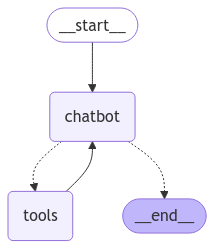

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [ ]:
config = {"configurable": {"thread_id": "10"}}

while True:
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  analyse ticket id 100
Assistant: 
INSIDE SUMMARIZE NODE 100
Subject : Order 8
User query : 
Dear Support Team,  I am deeply disappointed that my USB-C Charger (Order #8), expected by Dec 23, did not arrive in time for an important occasion. To make matters worse, I was informed I cannot cancel the order. Can you please verify whether I can get a refund or not. Please provide an update on when I will receive the item.  I hope for a prompt resolution.  Thank you.

Assistant: ["ticket_id: 100", "Ticket Summary: Summary: The customer, who is disappointed, mentions that their USB-C Charger (Order #8), expected by December 23, did not arrive on time. They express frustration over being unable to cancel the order and request a verification on whether they can receive a refund. Additionally, they seek an update on the delivery status of the item and hope for a prompt resolution. Customer Name is not provided."]
Assistant: 
INSIDE NL2SQL TOOL Get the delivery status and estimated deliver